<a href="https://colab.research.google.com/github/AI-RMF/AI-RTT/blob/main/AI_RMF_RTT_14_TF_Model_Card_Demo_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Starting Custom Model Card demonstration...
Building and training a simple model...
Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.6445 - loss: 1.1405 - val_accuracy: 0.9160 - val_loss: 0.2570
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9509 - loss: 0.1753 - val_accuracy: 0.9360 - val_loss: 0.2027
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9631 - loss: 0.1185 - val_accuracy: 0.9600 - val_loss: 0.1137
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9760 - loss: 0.0805 - val_accuracy: 0.9530 - val_loss: 0.1335
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9820 - loss: 0.0637 - val_accuracy: 0.9690 - val_loss: 0.0964
Test accuracy: 0.9690
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Calculating evaluation metrics...

Classification Report:
              precision    recall  f1-score   support
0              0.975904  0.952941  0.964286    85.000
1              0.992126  1.000000  0.996047   12


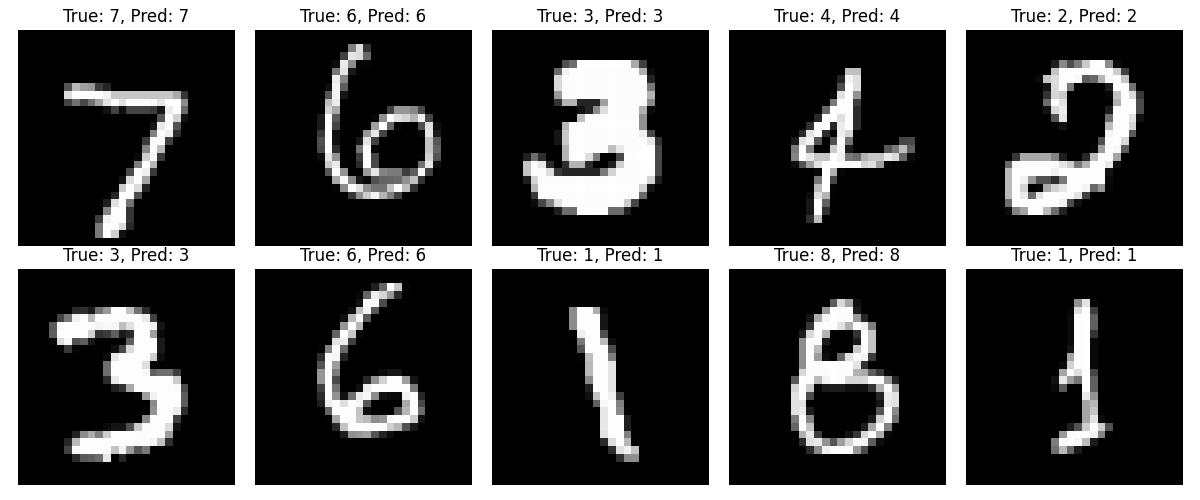
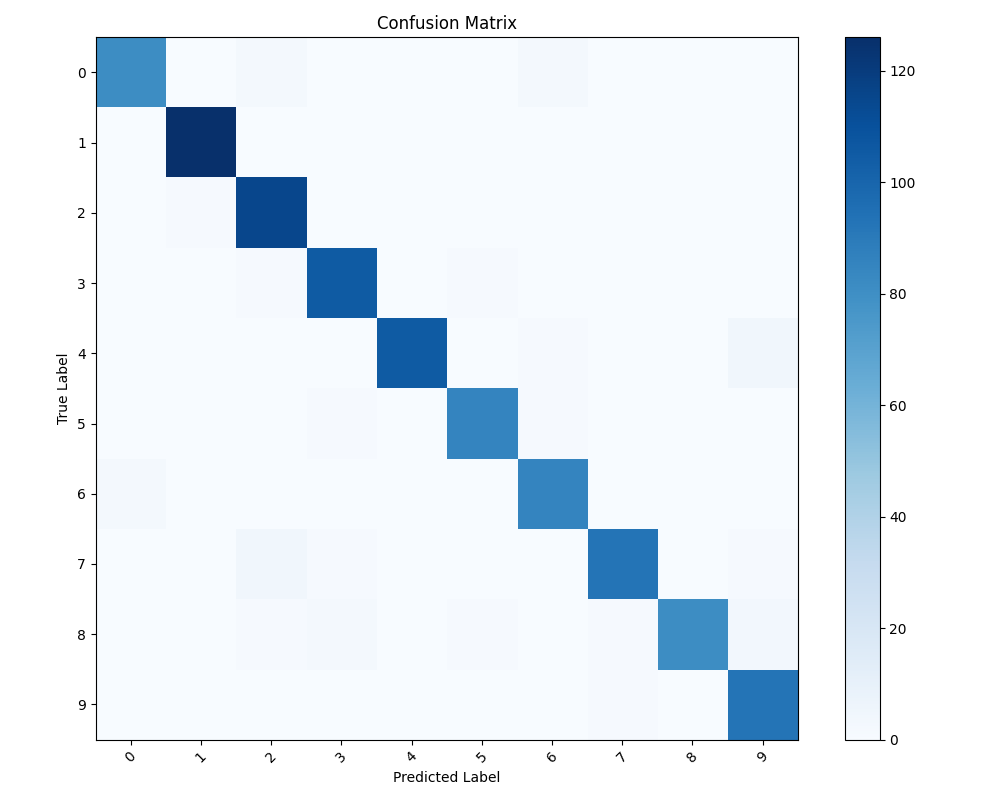
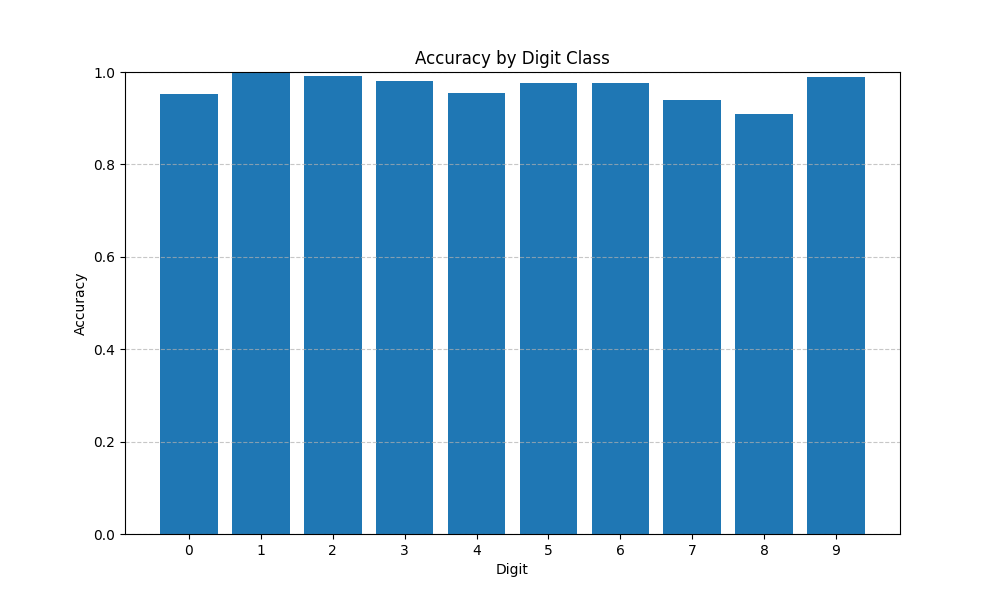


Key benefits of using Model Cards:
1. Transparency: Communicates model capabilities and limitations
2. Documentation: Creates standardized, shareable model information
3. Responsible AI: Promotes ethical AI development practices
4. Compliance: Helps meet emerging regulatory requirements
5. Collaboration: Facilitates knowledge sharing among teams

This custom implementation provides similar functionality to the TensorFlow Model Card Toolkit
while avoiding dependency issues.


In [2]:
# Custom TensorFlow Model Card Demo
# This script demonstrates how to create model cards without the model-card-toolkit package

# Install required packages
!pip install -q tensorflow>=2.4.0
!pip install -q matplotlib pandas scikit-learn jinja2

import os
import json
import tempfile
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import jinja2
import base64
from io import BytesIO
from datetime import date
from IPython.display import HTML, display

# Create a directory for our model card assets
MODEL_CARD_DIR = "model_card"
os.makedirs(MODEL_CARD_DIR, exist_ok=True)

# Step 1: Build and train a simple model
def build_and_train_model():
    """Build and train a simple classification model on the MNIST dataset."""
    print("Building and training a simple model...")

    # Load the MNIST dataset
    (train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.mnist.load_data()

    # Use only a subset for faster demonstration
    train_data = train_data[:5000] / 255.0
    test_data = test_data[:1000] / 255.0
    train_labels = train_labels[:5000]
    test_labels = test_labels[:1000]

    # Reshape for the model
    train_data = train_data.reshape(-1, 28, 28, 1)
    test_data = test_data.reshape(-1, 28, 28, 1)

    # Create a simple CNN model
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    model.fit(
        train_data, train_labels,
        epochs=5,
        validation_data=(test_data, test_labels),
        verbose=1
    )

    # Save the model with proper .keras extension
    model_path = os.path.join(MODEL_CARD_DIR, "mnist_model.keras")
    model.save(model_path)

    # Evaluate the model
    test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=0)
    print(f"Test accuracy: {test_acc:.4f}")

    # Get predictions for metrics calculation
    predictions = model.predict(test_data)
    pred_labels = np.argmax(predictions, axis=1)

    return model, train_data, train_labels, test_data, test_labels, pred_labels, model_path

# Step 2: Calculate evaluation metrics for different slices
def calculate_metrics(test_data, test_labels, pred_labels):
    """Calculate evaluation metrics for the model, including metrics for specific slices."""
    print("Calculating evaluation metrics...")

    # Overall accuracy
    overall_accuracy = np.mean(pred_labels == test_labels)

    # Initialize metrics dictionary
    metrics = {
        'slices': {
            'overall': {
                'accuracy': overall_accuracy
            }
        }
    }

    # Calculate metrics for each digit class (0-9)
    for digit in range(10):
        # Create mask for this digit
        mask = test_labels == digit

        if np.sum(mask) > 0:  # Ensure there's at least one sample
            slice_accuracy = np.mean(pred_labels[mask] == test_labels[mask])

            metrics['slices'][f'digit_{digit}'] = {
                'accuracy': slice_accuracy
            }

    # Create confusion matrix
    cm = confusion_matrix(test_labels, pred_labels)

    # Calculate precision, recall for each class
    report = classification_report(test_labels, pred_labels, output_dict=True)

    return metrics, cm, report

# Step 3: Create visualizations for the model card
def create_visualizations(test_data, test_labels, pred_labels, confusion_mat):
    """Create visualizations for the model card."""
    print("Creating visualizations...")

    # Sample images with predictions
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        img_idx = i * 100  # Just to get some variety
        ax.imshow(test_data[img_idx].reshape(28, 28), cmap='gray')
        true_label = test_labels[img_idx]
        pred_label = pred_labels[img_idx]
        ax.set_title(f"True: {true_label}, Pred: {pred_label}")
        ax.axis('off')

    # Save plot as base64 for HTML embedding
    buffer = BytesIO()
    plt.tight_layout()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    samples_base64 = base64.b64encode(buffer.read()).decode('utf-8')
    plt.savefig(os.path.join(MODEL_CARD_DIR, "sample_images.png"))
    plt.close()

    # Confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(10)
    plt.xticks(tick_marks, range(10), rotation=45)
    plt.yticks(tick_marks, range(10))

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

    # Save plot as base64 for HTML embedding
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    cm_base64 = base64.b64encode(buffer.read()).decode('utf-8')
    plt.savefig(os.path.join(MODEL_CARD_DIR, "confusion_matrix.png"))
    plt.close()

    # Per-class accuracy bar chart
    accuracies = []
    for i in range(10):
        mask = test_labels == i
        if np.sum(mask) > 0:
            acc = np.mean(pred_labels[mask] == test_labels[mask])
            accuracies.append(acc)
        else:
            accuracies.append(0)

    plt.figure(figsize=(10, 6))
    plt.bar(range(10), accuracies)
    plt.xlabel('Digit')
    plt.ylabel('Accuracy')
    plt.title('Accuracy by Digit Class')
    plt.xticks(range(10))
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Save plot as base64 for HTML embedding
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    acc_base64 = base64.b64encode(buffer.read()).decode('utf-8')
    plt.savefig(os.path.join(MODEL_CARD_DIR, "accuracy_by_class.png"))
    plt.close()

    return {
        'samples_base64': samples_base64,
        'cm_base64': cm_base64,
        'acc_base64': acc_base64
    }

# Step 4: Create a custom model card using Jinja2 templates
def create_custom_model_card(metrics, report, model_path, viz_data):
    """Create a custom model card using Jinja2 templates."""
    print("Creating custom model card...")

    # Prepare performance metrics for the template
    performance_metrics = []

    # Add overall metrics
    performance_metrics.append({
        'slice': 'Overall',
        'accuracy': f"{metrics['slices']['overall']['accuracy']:.4f}"
    })

    # Add per-digit metrics
    for digit in range(10):
        slice_name = f"digit_{digit}"
        if slice_name in metrics['slices'] and str(digit) in report:
            performance_metrics.append({
                'slice': f"Digit {digit}",
                'accuracy': f"{metrics['slices'][slice_name]['accuracy']:.4f}",
                'precision': f"{report[str(digit)]['precision']:.4f}",
                'recall': f"{report[str(digit)]['recall']:.4f}",
                'f1_score': f"{report[str(digit)]['f1-score']:.4f}"
            })

    # Define the model card template using Jinja2
    model_card_template = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>Model Card: MNIST Digit Classifier</title>
        <style>
            body { font-family: Arial, sans-serif; line-height: 1.6; max-width: 1000px; margin: 0 auto; padding: 20px; }
            h1 { color: #333; border-bottom: 2px solid #eee; padding-bottom: 10px; }
            h2 { color: #444; margin-top: 20px; }
            table { border-collapse: collapse; width: 100%; margin: 20px 0; }
            th, td { border: 1px solid #ddd; padding: 8px; text-align: left; }
            th { background-color: #f2f2f2; }
            .metric-card { border: 1px solid #ddd; border-radius: 5px; padding: 15px; margin-bottom: 20px; }
            .limitation { background-color: #fff8dc; padding: 10px; margin: 5px 0; border-left: 3px solid #ffd700; }
            .use-case { background-color: #f0f8ff; padding: 10px; margin: 5px 0; border-left: 3px solid #1e90ff; }
            .ethical { background-color: #fff0f5; padding: 10px; margin: 5px 0; border-left: 3px solid #ff69b4; }
            .version-info { color: #666; font-size: 0.9em; }
            img { max-width: 100%; height: auto; }
        </style>
    </head>
    <body>
        <h1>Model Card: MNIST Digit Classifier</h1>
        <p class="version-info">Version: 1.0.0 | Created: {{ date }}</p>

        <h2>Model Overview</h2>
        <p>
            A simple convolutional neural network trained to classify handwritten digits
            from the MNIST dataset. This model demonstrates the use of model cards for
            responsible AI development.
        </p>

        <h2>Model Details</h2>
        <table>
            <tr>
                <th>Property</th>
                <th>Value</th>
            </tr>
            <tr>
                <td>Model Architecture</td>
                <td>Convolutional Neural Network (CNN)</td>
            </tr>
            <tr>
                <td>Training Dataset</td>
                <td>MNIST Train Split (5,000 samples)</td>
            </tr>
            <tr>
                <td>Evaluation Dataset</td>
                <td>MNIST Test Split (1,000 samples)</td>
            </tr>
            <tr>
                <td>Model Owners</td>
                <td>Demo User (demo@example.com)</td>
            </tr>
            <tr>
                <td>References</td>
                <td>
                    <ul>
                        <li><a href="https://www.tensorflow.org/datasets/catalog/mnist">MNIST Dataset</a></li>
                        <li><a href="https://www.tensorflow.org/responsible_ai">TensorFlow Responsible AI</a></li>
                    </ul>
                </td>
            </tr>
        </table>

        <h2>Sample Predictions</h2>
        <div class="metric-card">
            <img src="data:image/png;base64,{{ viz_data.samples_base64 }}" alt="Sample Predictions">
            <p><em>Sample digits from the test set with true and predicted labels</em></p>
        </div>

        <h2>Performance Metrics</h2>
        <div class="metric-card">
            <h3>Confusion Matrix</h3>
            <img src="data:image/png;base64,{{ viz_data.cm_base64 }}" alt="Confusion Matrix">
            <p><em>Confusion matrix showing prediction distribution across classes</em></p>
        </div>

        <div class="metric-card">
            <h3>Accuracy by Digit Class</h3>
            <img src="data:image/png;base64,{{ viz_data.acc_base64 }}" alt="Accuracy by Class">
            <p><em>Accuracy comparison across the different digit classes</em></p>
        </div>

        <h3>Detailed Metrics</h3>
        <table>
            <tr>
                <th>Data Slice</th>
                <th>Accuracy</th>
                <th>Precision</th>
                <th>Recall</th>
                <th>F1 Score</th>
            </tr>
            {% for metric in performance_metrics %}
            <tr>
                <td>{{ metric.slice }}</td>
                <td>{{ metric.accuracy }}</td>
                <td>{{ metric.precision if 'precision' in metric else '-' }}</td>
                <td>{{ metric.recall if 'recall' in metric else '-' }}</td>
                <td>{{ metric.f1_score if 'f1_score' in metric else '-' }}</td>
            </tr>
            {% endfor %}
        </table>

        <h2>Considerations and Limitations</h2>

        <h3>Limitations</h3>
        <div class="limitation">The model was trained on a small subset of MNIST for demonstration purposes</div>
        <div class="limitation">The model may not perform well on handwritten digits that differ significantly from the MNIST style</div>
        <div class="limitation">The model has not been evaluated on adversarial examples</div>

        <h3>Use Cases</h3>
        <div class="use-case">Educational demonstration of model cards</div>
        <div class="use-case">Simple digit recognition tasks</div>
        <div class="use-case">Integration in handwriting recognition systems</div>

        <h3>Ethical Considerations</h3>
        <div class="ethical">
            <strong>Data Collection Biases:</strong> The MNIST dataset is widely studied and relatively balanced, but may not represent all handwriting styles
        </div>
        <div class="ethical">
            <strong>Environmental Impact:</strong> This is a lightweight model with minimal computational requirements
        </div>

        <footer>
            <p><small>This model card was generated using a custom implementation inspired by TensorFlow's Model Card Toolkit.</small></p>
        </footer>
    </body>
    </html>
    """

    # Create Jinja2 template
    template = jinja2.Template(model_card_template)

    # Render template with data
    current_date = date.today().strftime("%Y-%m-%d")
    html_content = template.render(
        performance_metrics=performance_metrics,
        viz_data=viz_data,
        date=current_date
    )

    # Save model card as HTML
    model_card_html_path = os.path.join(MODEL_CARD_DIR, "model_card.html")
    with open(model_card_html_path, "w") as f:
        f.write(html_content)

    # Create a JSON version with the same data
    model_card_data = {
        "model_details": {
            "name": "MNIST Digit Classifier",
            "version": "1.0.0",
            "overview": "A simple convolutional neural network trained to classify handwritten digits.",
            "architecture": "Convolutional Neural Network (CNN)",
            "owners": [{"name": "Demo User", "contact": "demo@example.com"}],
            "references": [
                "https://www.tensorflow.org/datasets/catalog/mnist",
                "https://www.tensorflow.org/responsible_ai"
            ]
        },
        "training_data": {
            "dataset": "MNIST Train Split (5,000 samples)"
        },
        "evaluation_data": {
            "dataset": "MNIST Test Split (1,000 samples)"
        },
        "performance_metrics": performance_metrics,
        "considerations": {
            "limitations": [
                "The model was trained on a small subset of MNIST for demonstration purposes",
                "The model may not perform well on handwritten digits that differ significantly from the MNIST style",
                "The model has not been evaluated on adversarial examples"
            ],
            "use_cases": [
                "Educational demonstration of model cards",
                "Simple digit recognition tasks",
                "Integration in handwriting recognition systems"
            ],
            "ethical_considerations": [
                {
                    "name": "Data Collection Biases",
                    "mitigation_strategy": "The MNIST dataset is widely studied and relatively balanced, but may not represent all handwriting styles"
                },
                {
                    "name": "Environmental Impact",
                    "mitigation_strategy": "This is a lightweight model with minimal computational requirements"
                }
            ]
        }
    }

    # Save model card as JSON
    model_card_json_path = os.path.join(MODEL_CARD_DIR, "model_card.json")
    with open(model_card_json_path, "w") as f:
        json.dump(model_card_data, f, indent=2)

    print(f"Model card generated and saved to {MODEL_CARD_DIR}")
    return model_card_html_path, model_card_json_path

# Main execution
def main():
    print("Starting Custom Model Card demonstration...")

    # Build and train model
    model, train_data, train_labels, test_data, test_labels, pred_labels, model_path = build_and_train_model()

    # Calculate evaluation metrics
    metrics, confusion_mat, report = calculate_metrics(test_data, test_labels, pred_labels)
    print("\nClassification Report:")
    print(pd.DataFrame(report).T)

    # Create visualizations
    viz_data = create_visualizations(test_data, test_labels, pred_labels, confusion_mat)

    # Create model card
    html_path, json_path = create_custom_model_card(metrics, report, model_path, viz_data)

    print(f"\nDemonstration complete! Model card available at: {html_path}")

    # Display the model card in Colab
    with open(html_path, 'r') as f:
        html_content = f.read()
    display(HTML(html_content))

    print("\nKey benefits of using Model Cards:")
    print("1. Transparency: Communicates model capabilities and limitations")
    print("2. Documentation: Creates standardized, shareable model information")
    print("3. Responsible AI: Promotes ethical AI development practices")
    print("4. Compliance: Helps meet emerging regulatory requirements")
    print("5. Collaboration: Facilitates knowledge sharing among teams")

    print("\nThis custom implementation provides similar functionality to the TensorFlow Model Card Toolkit")
    print("while avoiding dependency issues.")

if __name__ == "__main__":
    main()